In [90]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [11]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [13]:
client.cluster

In [4]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [ ]:
def gmean(da,la,cf=1):
    #global mean
    if 'gridcell' in da.coords:
        xg=cf/la.sum(dim='gridcell')*(la*da).sum(dim='gridcell').compute()
    else:
        xg=cf/la.sum(dim=['lat','lon'])*(la*da).sum(dim=['lat','lon']).compute()
    return xg

### test sparsegrid pft-averaging

In [355]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values]

In [6]:
#locate the output files
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h1'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1980
files = np.array(files)[yrs>=yr0]

In [20]:
#read in the dataset
def preprocess(ds):
    dvs=['TLAI','pfts1d_wtgcell']
    return ds[dvs]
ds = xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                       decode_times=False,preprocess=preprocess)

In [341]:
#add some extra variables
extras=['pfts1d_itype_veg','pfts1d_lat','pfts1d_lon']
tmp=xr.open_dataset(files[0])
for ee in extras:
    ds[ee]=tmp[ee]
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')


In [389]:
def get_ix(ds,la):
    #generate the 2d index for vegetated area of lat/lon grid
    ixp=ds.pfts1d_itype_veg==1
    npft=ixp.sum().values
    nlon=len(la.lon)
    nlat=len(la.lat)
    dlat=(la.lat[1]-la.lat[0]).values/2
    dlon=(la.lon[1]-la.lon[0]).values/2
    lats=xr.DataArray(np.tile(la.lat.values.reshape([-1,1,1]),[1,nlon,npft]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(la.lon.values.reshape([1,-1,1]),[nlat,1,npft]),dims=['lat','lon','pft'])
    ix=((abs(lats-ds.pfts1d_lat[ixp])<dlat)&(abs(lons-ds.pfts1d_lon[ixp])<dlon)).sum(dim='pft')==1
    ix['lat']=la.lat
    ix['lon']=la.lon
    return ix

In [421]:
ix=get_ix(ds,la) #only need this once, same for all pfts

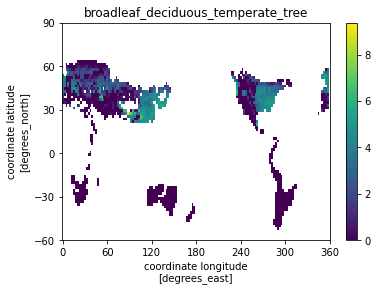

In [423]:
#here's how it works:
pft=7
out=np.zeros(la.shape)+np.nan
ixpft=ds.pfts1d_itype_veg==pft    #index for pft==pft
out[ix]=ds.TLAI.isel(time=6,pft=ixpft)

#plotting
da=xr.DataArray(out,coords=[la.lat,la.lon])
da.plot()
plt.xticks(60*np.arange(7))
plt.yticks(-60+30*np.arange(6))
plt.ylim([-60,90])
plt.title(pfts[pft]);

In [425]:
def pftgrid(da,ix):
    #regrid da from pfts1d -> lat,lon,pft
    
    #set up dims for outgoing data array
    dims=[]
    s=[]
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    #preallocate matrix
    out=np.zeros(s)+np.nan
    
    #regrid
    das=[]
    ix0=[slice(None) for i in range(ndims-2)]
    ix2=tuple([*ix0,ix])
    
    das=[]
    for pft in 1+np.arange(16):
        ixp=ds.pfts1d_itype_veg==pft
        out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))
    
    da_out=xr.concat(das,dim='pft')
    da_out['pft']=1+np.arange(16)
    da_out['lat']=ix.lat
    da_out['lon']=ix.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]
        
    return da_out

In [426]:
da=ds.pfts1d_wtgcell
ix=get_ix(ds,la)
ww=pftgrid(da,ix)  #slower because I'm doing the full timeseries

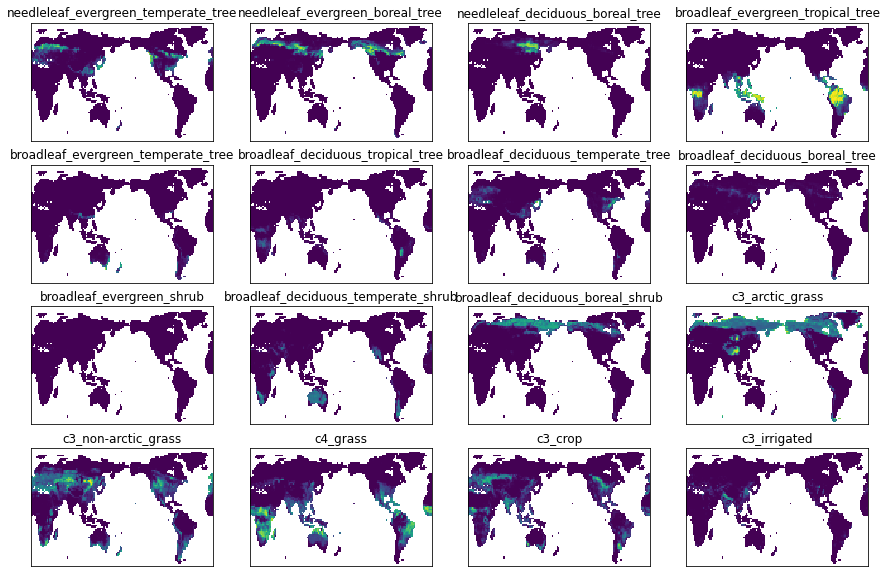

In [427]:
plt.figure(figsize=[15,10])
for pft in 1+np.arange(16):
    plt.subplot(4,4,pft)
    ww.sel(pft=pft).isel(time=-1).plot(vmax=1,add_colorbar=False)
    plt.title(pfts[pft])
    plt.ylim([-60,90])
    plt.xticks([]);
    plt.yticks([]);
    plt.ylabel('')
    plt.xlabel('')
plt.savefig('../figs/pft/pft_area.png',bbox_inches='tight',dpi=300)

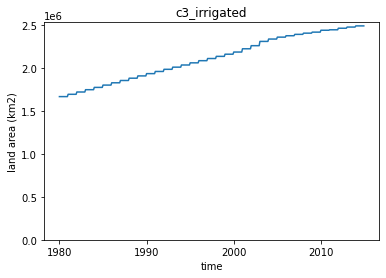

In [441]:
pft=16
(la*ww.sel(pft=pft)).sum(dim=['lat','lon']).plot()
plt.title(pfts[pft])
plt.ylim(bottom=0)
plt.ylabel('land area (km2)');

In [437]:
pfts[16]

'c3_irrigated'